<a href="https://colab.research.google.com/github/GeonHyeongLee/first-project/blob/master/DQN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [23]:
!apt-get install -y cmake zlib1g-dev libjpeg-dev xvfb \
    xorg-dev libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu10).
xorg-dev is already the newest version (1:7.7+23ubuntu2).
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
swig is already the newest version (4.0.2-1ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
libsdl2-dev is already the newest version (2.0.20+dfsg-2ubuntu1.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [24]:
!pip install gym[classic_control]

In [25]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from base64 import b64encode
from glob import glob
from IPython.display import HTML
from IPython import display as ipy_display
# import gymnasium as gym
from gym import logger as gym_logger
from gym.wrappers.record_video import RecordVideo
import math

In [26]:
from natsort import natsorted

def show_video(env_name , mode='train', filename=None):
    mp4_list = glob(env_name+'/'+mode+'/*.mp4')
    if mp4_list:
        if filename :
            file_lists = glob(mode+'/'+filename)
            if not file_lists:
                print('No {} found'.format(filename))
                return -1
            mp4 = file_lists[0]

        else:
            mp4 = natsorted(mp4_list)[-1]

        print(mp4)
        video = open(mp4, 'r+b').read()
        encoded = b64encode(video)
        ipy_display.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')
        return -1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import numpy as np
import random
import gym
from matplotlib import pyplot as plt

# 함수 선언

## get_network(state_size, action_size)


In [28]:
def get_network(state_size, action_size):
  # Q-네트워크 구조 구현
  # 3개 Dense(Fully connected) 신경망
  # 히든레이터 층수: 24(ReLU), 24(ReLU)
  # 입력: 현재 상태
  # 출력: 모든 가능한 행동에 대한 행동-가치함수 값

  network = Sequential()

  # TODO #
  network.add(Dense(24, activation = 'relu', input_shape = (state_size,)))
  network.add(Dense(24, activation = 'relu'))
  network.add(Dense(action_size))

  return network

정답 확인

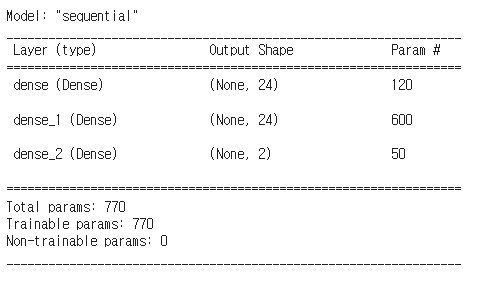

In [29]:
network = get_network(4, 2)
network.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 24)                120       
                                                                 
 dense_37 (Dense)            (None, 24)                600       
                                                                 
 dense_38 (Dense)            (None, 2)                 50        
                                                                 
Total params: 770 (3.01 KB)
Trainable params: 770 (3.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## update_target_network(q_network, target_q_network)

In [30]:
def update_target_network(q_network, target_q_network):
  # Q-네트워크 가중치를 Target-Q-네트워크의 가중치로 설정
  # get_weights(), set_weights()

  # TODO #
  target_q_network.set_weights(q_network.get_weights())


  return target_q_network

정답 확인

In [31]:
network1 = get_network(4, 2)
network2 = get_network(4, 2)
network2 = update_target_network(network1, network2)
for i in range(len(network1.get_weights())):
    if (network1.get_weights()[i] == network2.get_weights()[i]).all() and (network1 != network2) :
        answer = True
    else:
        answer = False
        break
print(answer)

True


## policy(state, epsilon, q_network)

In [51]:
def policy(state, epsilon, action_size, q_network):
  # 입력받은 상태에 대하여 행동을 결정하는 함수 구현
  # 엡실론-그리디 알고리즘 구현

  # TODO # epsilon보다 작을 경우 random action, 클 경우 q_network의 최대 보상 행동
  # np(numpy)
  if (np.random.uniform(0,1) < epsilon): # 행동을 랜덤으로
    action = np.random.choice([x for x in range(action_size)])
  else:
    out = q_network(state) # q_network의 최대 보상 행동, 랜덤한 행동 중 가장 큰 index 가지도록
    action = np.argmax(out)


  return action

정답 확인

In [53]:
# 여기서는 상태에 따라 동일한 출력을 반환하는 모델을 사용합니다.
def mock_q_network(state):
    return np.array([1, 0, 0, 0])  # 항상 첫 번째 행동을 선호하도록 설정

# 검증 코드
def test_policy():
    np.random.seed(42)  # 결과의 일관성을 위해 시드 설정

    # 엡실론이 1일 때 항상 무작위 행동을 선택해야 합니다.
    for _ in range(1000):
        assert policy(0, 1, 3, mock_q_network) in [0, 1, 2]

    # 엡실론이 0일 때 항상 q_network의 최대값 행동을 선택해야 합니다.
    for _ in range(1000):
        assert policy(0, 0, 3, mock_q_network) == 0

    print("All tests passed!")

# 검증 코드 실행
test_policy()


All tests passed!


## remember(buffer, state, action, reward, next_state, done)

In [56]:
def remember(buffer, state, action, reward, next_state, done):
  # 입력받은 상태, 행동, 보상, 다음상태, done flag를 리플레이 버퍼에 축적하는 함수 구현

  # TODO # buffer는 list고 위에 것들 넣어주기
  buffer.append((state,action, reward, next_state, done))


  return buffer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


정답 확인

In [57]:
testbuffer = []

testbuffer = remember(testbuffer,[0.01537205, -0.00303604, -0.01423469, -0.03586012], 0, 0.1, [0.01531132, -0.197951, -0.01495189, 0.25229785], False)
testbuffer = remember(testbuffer, [0.01531132, -0.197951, -0.01495189, 0.25229785], 0, 0.1, [0.0113523, -0.3928563, -0.00990593, 0.5402274 ], False)
testbuffer = remember(testbuffer, [0.0113523, -0.3928563, -0.00990593, 0.5402274], 0, 0.1, [0.00349518, -0.58783764, 0.00089862, 0.8297728 ], False)

testbuffer == [([0.01537205, -0.00303604, -0.01423469, -0.03586012],
  0,
  0.1,
  [0.01531132, -0.197951, -0.01495189, 0.25229785],
  False),
 ([0.01531132, -0.197951, -0.01495189, 0.25229785],
  0,
  0.1,
  [0.0113523, -0.3928563, -0.00990593, 0.5402274],
  False),
 ([0.0113523, -0.3928563, -0.00990593, 0.5402274],
  0,
  0.1,
  [0.00349518, -0.58783764, 0.00089862, 0.8297728],
  False)]

True

## train(epsilon, epsilon_min, epsilon_decay, buffer, batch_size, target_q_network, gamma, q_network, action_size ,loss_fn, optimizer)

In [ ]:
def train(epsilon, epsilon_min, epsilon_decay, buffer, batch_size, target_q_network, gamma, q_network, action_size ,loss_fn, optimizer):

  # TODO #

  # GLIE 구현
  ##### Update ######
  epsilon =

  # 리플레이 버퍼에서 배치사이즈만큼 랜덤하게 추출하여 mini_batch 구현
  # random.sample 함수 활용
  # https://docs.python.org/3/library/random.html?highlight=random%20sample#random.sample
  mini_batch =

  # mini_batch에서 각 아래 정보로 분리하기
  states, actions, rewards, next_states, dones = zip(*mini_batch)

  # 분리된 정보를 tensor 형태로 변환
  states =
  actions =
  rewards =
  next_states =
  dones =

  # 학습 Target 정의
  # r + gamma * max_q_target(next_s)
  # mini_batch 단위로 elements-wise하게 계산되어야 합니다.
  # max_q_target을 위해서 행렬 내 최대값을 반환해주는 np.amax 함수 활용
  # (참조: https://numpy.org/doc/stable/reference/generated/numpy.amax.html)
  # (아래 코드를 활용해 보시기 바랍니다.
  # np.amax([[0.1, 0.9], [0.7, 0.3]], axis=-1))
  # 에피소드의 마지막 상태의 경우, only 보상이 target 값이 된다.
  ##### Update ######
  q_next =
  max_q_next =
  targets =

  # q_network 학습
  # tf.GradientTape() 함수를 활용하여 자동미분 후 학습에 활용
  # (참조: https://teddylee777.github.io/tensorflow/gradient-tape)
  with tf.GradientTape() as tape:
      ##### Update ######
      q =
      one_hot_a =
      q_sa =
      # 오차 계산
      loss =

  # 손실함수를 통해 계산한 오차를 네트워크 가중치로 미분!
  grads = tape.gradient(loss, q_network.trainable_weights)
  # 미분값을 기준으로 각 네트워크 가중치를 업데이트!
  optimizer.apply_gradients(zip(grads, q_network.trainable_weights))

  return epsilon, q_network

# 환경 및 하이퍼파라미터

## 환경 정의

In [ ]:
# 새롭게 학습을 시작할 때 기존 녹화 영상을 지워주는 셀
!rm -rf MountainCar-v0
!rm -rf Acrobot-v1

In [ ]:
# --------------------
# ENV_NAME = "Acrobot-v1"
# ENV_NAME = "MountainCar-v0"
# --------------------
ENV_NAME = "MountainCar-v0"
env = gym.make(ENV_NAME, render_mode="rgb_array")

# 비디오 레코딩
env = RecordVideo(env, f'./{ENV_NAME}/train',  episode_trigger = lambda episode_number: True)

## 하이퍼파라미터 설정

In [ ]:
# 감쇠율 및 엡실론 정의
# TODO #
# Greedy in the limit of infinite exploration (GLIE) 정책 고려
##### Update ######
gamma =
epsilon =
epsilon_decay =
epsilon_min =

# 리플레이 버퍼 크기 및 학습 시작 크기 정의
# TODO #
buffer_size =
buffer_size_train_start =

# 리플레이 버퍼 정의
# deque 자료구조 활용 (참조: https://chaewonkong.github.io/posts/python-deque.html)
# TODO #
buffer =

# 인공신경망 학습 하이퍼파라미터 설정
# TODO #
##### Update ######
loss_fn =
learning_rate =
optimizer =
batch_size =

## Q-네트워크 및 타겟(Q)-네트워크 정의

In [ ]:
# 환경의 상태와 행동 크기 정의
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Q-네트워크 및 타겟(Q)-네트워크 정의
q_network =
target_q_network =

# 타겟(Q)-네트워크 파라미터 복제 함수 정의
target_q_network =

# DQN 학습

In [ ]:
scores, avg_scores, episodes = [], [], []

# 반복 학습 에피소드 수 정의
num_episode = 100

for epoch in range(num_episode):
    # done flag와 score 값 초기화
    done = False
    score = 0

    # 환경 reset을 통해 초기 상태 정의
    state = env.reset()

    while not done:
        # 현재 상태에 대하여 행동 정의
        action = policy(state[np.newaxis,:], epsilon, action_size, q_network)

        # env.step 함수를 이용하여 행동에 대한 다음 상태, 보상, done flag 등 획득
        next_state, reward, done, info = env.step(action)

        # 해당 에피소드의 최종 score를 위해 reward 값 누적
        score += reward

        # 기본 환경은 매 time step마다 -1의 보상을 준다.
        # 자신만의 보상가설을 만들어 학습 가능
        # TODO #
        reward =

        # 획득된 상태, 행동, 보상, 다음상태, done flag를 리플레이 버퍼에 축적
        buffer =

        # 다음 상태를 현재 상태로 정의
        state =

        # buffer 크기가 일정 기준 이상 쌓이면 학습 진행
        # TODO #

        if done:
            # 에피소드가 종료되면 target_q_network 파라미터 복제
            # TODO #
            target_q_network = update_target_network(q_network,target_q_network)

            # 에피소드 종료마다 결과 그래프 저장
            scores.append(score)
            avg_scores.append(np.mean(scores[-10:]))
            episodes.append(epoch)
            plt.plot(episodes, avg_scores, 'b')
            plt.xlabel('episode')
            plt.ylabel('average score')
            plt.savefig('graph.png')

            # 에피소드 종료마다 결과 출력
            print('episode: {:3d} | avg_score: {:3.2f} | buffer_size: {:4d} | epsilon: {:.4f}'.format(epoch,
                                                                                           np.mean(scores[-10:]),
                                                                                           len(buffer),
                                                                                           epsilon))

env.close()

In [ ]:
 show_video(env_name = ENV_NAME)

# 학습된 DQN 정책 Greedy Test

In [ ]:
env = gym.make(ENV_NAME, render_mode="rgb_array")

# 비디오 레코딩
env = RecordVideo(env, f'./{ENV_NAME}/test',  episode_trigger = lambda episode_number: True)

# greedy policy
epsilon = 0.0

score = 0
state = env.reset()
done = False

while not done:

    # 현재 상태에 대하여 행동 정의
    action = policy(state[np.newaxis,:], epsilon, action_size, q_network)

    # env.step 함수를 이용하여 행동에 대한 다음 상태, 보상, done flag 등 획득
    next_state, reward, done, info = env.step(action)

    # 해당 에피소드의 최종 score를 위해 reward 값 누적
    score += reward

    # 다음 상태를 현재 상태로 정의
    state = next_state

print("Score: ", score)

In [ ]:
show_video(env_name = ENV_NAME ,mode='test')